In [1]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import osgeo.gdal
import urllib.request
import zipfile
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

In [2]:
save_path = os.path.join('../data/external/', 'denue')
urllib.request.urlretrieve(
            'https://www.inegi.org.mx/contenidos/masiva/denue/2019_11/denue_14_1119_shp.zip', save_path)

('../data/external/denue', <http.client.HTTPMessage at 0x7fe1f82c3f10>)

In [3]:

# define the name of the directory to be created
outputDirectory = '../data/external/denue_2019/'

try:
    os.makedirs(outputDirectory)
except IOError:
    print('cannot create', outputDirectory)
    
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    
    zip_ref.extractall(outputDirectory)

In [4]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']
consumed = 144.06 #Per roof median emission kWh/m²/yr https://insights.sustainability.google/places/ChIJOwV0Q_qxKIQR7NCkjDwfR-k/buildings
emission = 0.00041423 #total carbon intensity tCO2e/kWh https://insights.sustainability.google/places/ChIJOwV0Q_qxKIQR7NCkjDwfR-k/buildings
dist = 1000 #Catchment area in sq m.

In [5]:
gdf_est = aqiGDL.gdf_from_db('puntos_pip','Estaciones')
gdf_est = ox.project_gdf(gdf_est,to_crs='EPSG:32613')

In [6]:
gdf_est.head(1)

,Nombre,Latitud,Longitud,geometry
0,Mercado Municipal de Zapopan,20.722076,-103.391246,POINT (667520.005 2292221.880)


In [7]:
data = []
areas = {}
edges_data = []
for i in range(len(gdf_est)):
    x = gdf_est.at[i,'Longitud']
    y = gdf_est.at[i,'Latitud']
    est = gdf_est.at[i,'Nombre']
    point = (y, x)
    tags = {'building': True}
    gdf = ox.geometries_from_point(point, tags, dist=dist)
    gdf['Estacion'] = est
    # calculate the area in projected units (meters) of each building footprint
    gdf = ox.project_gdf(gdf)
    '''gdf['area'] = gdf.area
    gdf['kWh_year'] = gdf['area'] * potential'''
    data.append(gdf)
    #areas[est] = gdf['area'].sum()
    G = ox.graph_from_point(point,dist=dist)
    edges = ox.graph_to_gdfs(G, nodes=False)
    edges['Estacion'] = est
    edges = ox.project_gdf(edges)
    edges_data.append(edges)
    G = None
    edges = None

In [8]:
gdf_ = pd.concat(data, ignore_index=True)
edges = pd.concat(edges_data, ignore_index=True)

In [9]:
outputDirectory = '../data/external/denue_2019/'
denue = gpd.read_file(outputDirectory+'conjunto_de_datos/denue_inegi_14_.shp')
denue = ox.project_gdf(denue,to_crs='EPSG:32613')

In [10]:
#buffer_dist = 1000
buffer = gpd.GeoDataFrame({'geometry':gdf_est.buffer(dist),'Nombre':gdf_est['Nombre']},geometry='geometry',crs=gdf_est.crs)
#buffer['sum-length'] = gpd.sjoin(buffer,gdf_edge).groupby(['Name']).sum().reset_index()['length']
#res_intersection = gpd.overlay(buffer, gdf_edge, how='intersection')
buffer.head(1)

,geometry,Nombre
0,"POLYGON ((668520.005 2292221.880, 668515.190 2...",Mercado Municipal de Zapopan


<AxesSubplot:>

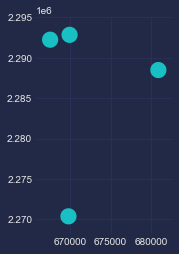

In [11]:
buffer.plot()

In [12]:
buffer = ox.project_gdf(buffer,to_crs='EPSG:4326')
tags = {'building': True}
gdf_building = gpd.GeoDataFrame()
#for b in range (len(buffer)):
for b in buffer.geometry:
    building = ox.geometries_from_polygon(b, tags)
    gdf_building = gdf_building.append(building)
    #print(buffer.iloc[b], gdf_building)

In [13]:
gdf_building.head(5)

,unique_id,osmid,element_type,nodes,amenity,building,name,geometry,religion,shop,...,ways,denomination,name:en,name:es,type,wikidata,wikipedia,note,sport,branch
0,way/158288130,158288130,way,"[1705161785, 1705161788, 1705161789, 170516178...",townhall,yes,Palacio Municipal de Zapopan,"POLYGON ((-103.39004 20.72165, -103.38996 20.7...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way/283473366,283473366,way,"[2873344087, 2873344088, 2873344089, 287334409...",marketplace,yes,Mercado del Mar Zapopan,"POLYGON ((-103.39038 20.73060, -103.39007 20.7...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way/302756363,302756363,way,"[3070298674, 6459556075, 8095768806, 809576880...",place_of_worship,yes,San Pedro Apostol,"POLYGON ((-103.39093 20.72229, -103.39058 20.7...",christian,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,way/346748206,346748206,way,"[6459556076, 3070298674, 3070298677, 645955607...",marketplace,yes,Mercado Municipal Lázaro Cádenas,"POLYGON ((-103.39141 20.72236, -103.39093 20.7...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,way/375937295,375937295,way,"[3792758960, 3792758961, 3792758962, 379275896...",NaN,yes,Jomers,"POLYGON ((-103.39007 20.72223, -103.38985 20.7...",NaN,clothes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

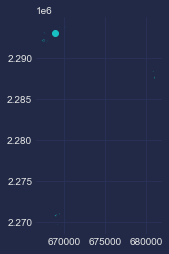

In [14]:
gdf_building = ox.project_gdf(gdf_building,to_crs='EPSG:32613')
gdf_building.plot()

In [15]:
buffer = ox.project_gdf(buffer,to_crs='EPSG:32613')
clip = gpd.clip(denue, buffer)
clip.head(5)

,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipoUniEco,latitud,longitud,fecha_alta,geometry
175,1699938,BORDADOS COMPUTARIZADOS,BORDADOS COMPUTARIZADOS SA DE CV,315223,Confección en serie de uniformes,0 a 5 personas,CALLE,MATAMOROS,CALLE,RAMON CORONA,...,0405,001,3336337986,ENRIQUEBORDADOS_PG@HOTMAIL.COM,None,Fijo,20.722907,-103.393044,2014-12,POINT (667331.837 2292311.943)
217,1710151,MAQUILA DE PANTALON,None,315229,Confección en serie de otra ropa exterior de m...,0 a 5 personas,PRIVADA,GENERAL AGUSTIN OLACHEA,CALLE,LICENCIADO LUIS MANUEL ROJAS,...,422A,008,3338610250,ANGELICA_RAMOS.16@HOTMAIL.COM,None,Fijo,20.731692,-103.368489,2014-12,POINT (669879.530 2293310.040)
250,1710150,MAQUILA DE PANTALONES,None,315229,Confección en serie de otra ropa exterior de m...,6 a 10 personas,PRIVADA,GENERAL AGUSTIN OLACHEA,CALLE,LICENCIADO LUIS MANUEL ROJAS,...,422A,008,3318262455,None,None,Fijo,20.731602,-103.368506,2010-07,POINT (669877.784 2293300.042)
261,6341013,JOYCE,GRUPO INDUSTRIAL LA CENTELLA SA DE CV,316211,Fabricación de calzado con corte de piel y cuero,31 a 50 personas,CALLE,GENERAL IGNACIO L. PESQUEIRA,CALLE,5,...,2435,033,None,EFRAINTOVAR@JOYCE.COM.MX,None,Fijo,20.723422,-103.363727,2010-07,POINT (670384.681 2292399.612)
289,8361570,CIRCLEPLAST,CIRCLEPLAST,314911,Confección de costales,11 a 30 personas,CALLE,SARCOFAGO,CALLE,LOURDES,...,4253,024,None,None,None,Fijo,20.724633,-103.382225,2019-11,POINT (668456.788 2292514.218)


In [16]:
gob = clip[clip['codigo_act'].str.startswith('931')]
gob.head(5)

,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipoUniEco,latitud,longitud,fecha_alta,geometry
361293,8691493,ÁREA OPERATIVA DE DIRECCIÓN DE MOVILIDAD Y TRA...,AYUNTAMIENTO,931410,Impartición de justicia y mantenimiento de la ...,51 a 100 personas,CALLE,HIDALGO,CALLE,EMILIANO ZAPATA,...,0405,012,3338182200,None,None,Fijo,20.721866,-103.391256,2019-11,POINT (667519.221 2292198.556)
361318,1964378,ATENCIÓN CIUDADANA,AYUNTAMIENTO DE ZAPOPAN,931210,Administración pública en general,0 a 5 personas,CALLE,28 DE ENERO,CALLE,20 DE NOVIEMBRE,...,0405,022,None,JUN.MICHEL@ZAPOPAN.GOB.MX,WWW.ZAPOPAN.GOB.MX,Fijo,20.721053,-103.389465,2014-12,POINT (667706.629 2292110.428)
361351,1848832,AYUNTAMIENTO ZAPOPAN,MANTENIMIENTO VEHICULAR,931210,Administración pública en general,11 a 30 personas,CALLE,ANTONIO MADRAZO,CALLE,NINGUNO,...,1032,017,3311993426,None,None,Fijo,20.733257,-103.361265,2014-12,POINT (670630.081 2293490.961)
362794,1711346,CENTRAL DE BOMBEROS,CENTRAL DE BOMBEROS BASE 3,931410,Impartición de justicia y mantenimiento de la ...,11 a 30 personas,CALLE,TONALA,CALLE,TLAQUEPAQUE,...,0378,012,None,None,None,Fijo,20.688466,-103.265688,2014-12,POINT (680637.220 2288636.042)
366549,8979306,ADMINISTRACIÓN MERCADO OBREROS DE CANANEA,None,931210,Administración pública en general,0 a 5 personas,CALLE,NINGUNO,CALLE,NATIVIDAD J. MACIAS,...,1032,002,None,None,None,Fijo,20.731084,-103.360037,2019-11,POINT (670760.414 2293251.695)


<AxesSubplot:>

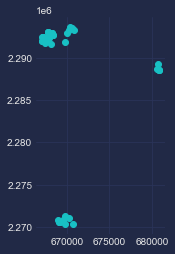

In [17]:
gob.plot()

In [18]:
gdf_building['area'] = gdf_building.geometry.area
gdf_building.head(5)

,unique_id,osmid,element_type,nodes,amenity,building,name,geometry,religion,shop,...,denomination,name:en,name:es,type,wikidata,wikipedia,note,sport,branch,area
0,way/158288130,158288130,way,"[1705161785, 1705161788, 1705161789, 170516178...",townhall,yes,Palacio Municipal de Zapopan,"POLYGON ((667646.561 2292175.764, 667653.861 2...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2629.265098
1,way/283473366,283473366,way,"[2873344087, 2873344088, 2873344089, 287334409...",marketplace,yes,Mercado del Mar Zapopan,"POLYGON ((667601.320 2293165.898, 667632.964 2...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2866.184752
2,way/302756363,302756363,way,"[3070298674, 6459556075, 8095768806, 809576880...",place_of_worship,yes,San Pedro Apostol,"POLYGON ((667553.020 2292245.380, 667589.201 2...",christian,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1974.767172
3,way/346748206,346748206,way,"[6459556076, 3070298674, 3070298677, 645955607...",marketplace,yes,Mercado Municipal Lázaro Cádenas,"POLYGON ((667502.503 2292253.625, 667553.020 2...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2853.281228
4,way/375937295,375937295,way,"[3792758960, 3792758961, 3792758962, 379275896...",NaN,yes,Jomers,"POLYGON ((667642.437 2292240.623, 667664.969 2...",NaN,clothes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.825914


In [19]:
mean_area = gdf_building.area.mean()
mean_area

1204.288763354648

In [20]:
edificios_gob = gpd.sjoin(buffer,gob,how='left').groupby(['Nombre']).count().reset_index()
edificios_gob = edificios_gob[['Nombre','id']]

In [21]:
edificios_gob['area'] = edificios_gob['id']*mean_area
edificios_gob['kWh_year'] = edificios_gob['area']*consumed
edificios_gob['tonCO₂eq'] = edificios_gob['kWh_year']*emission
edificios_gob.head(5)

,Nombre,id,area,kWh_year,tonCO₂eq
0,Centro Cultural Constitución Zapopan,6,7225.732580,1.040939e+06,431.188177
1,"Comisaría de la Policía Municipal de Tonalá, D...",5,6021.443817,8.674492e+05,359.323481
2,"LabASE, Laboratorio de Arquitectura Social Est...",9,10838.598870,1.561409e+06,646.782265
3,Mercado Municipal de Zapopan,42,50580.128061,7.286573e+06,3018.317237


In [22]:
edificios_gob_ = edificios_gob.merge(gdf_est, right_on='Nombre', left_on = 'Nombre')
edificios_gob_ = gpd.GeoDataFrame(edificios_gob_, crs = gdf_est.crs)
edificios_gob_.sort_values(by='tonCO₂eq', ascending=False, inplace=True)
edificios_gob_.head(1)

,Nombre,id,area,kWh_year,tonCO₂eq,Latitud,Longitud,geometry
3,Mercado Municipal de Zapopan,42,50580.128061,7.286573e+06,3018.317237,20.722076,-103.391246,POINT (667520.005 2292221.880)


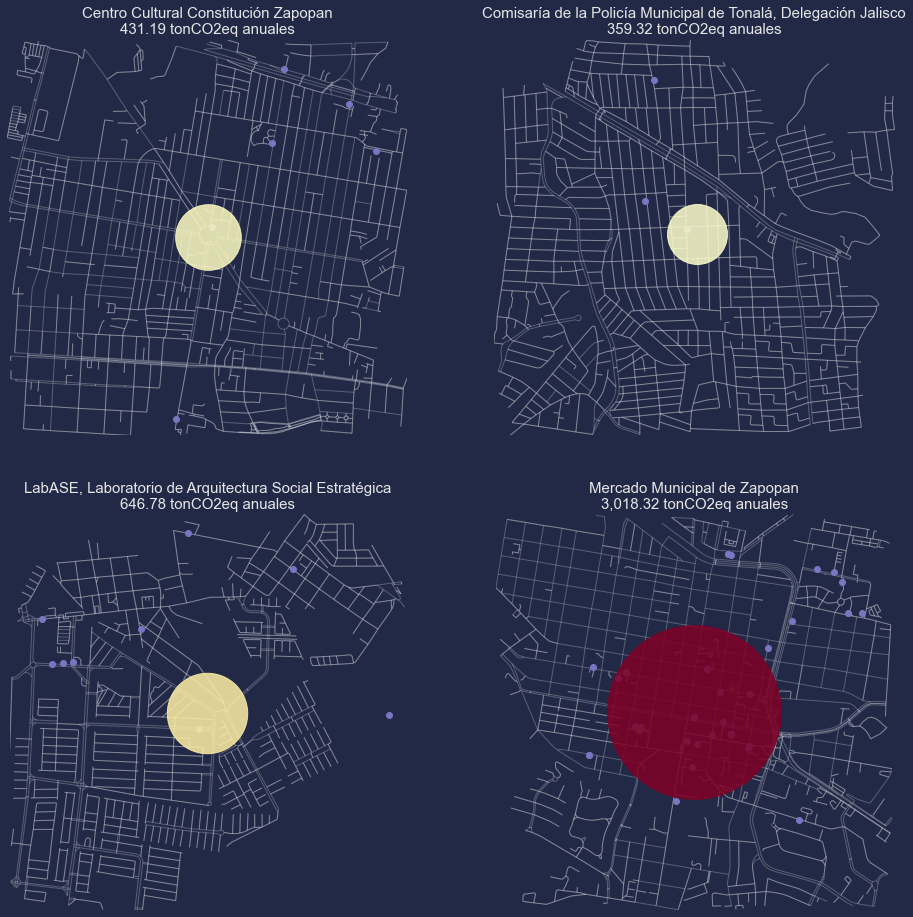

In [23]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

fig, axes = plt.subplots(2,2,figsize = (16,16))
for i, ax in zip(edificios_gob.index.tolist(), axes.flatten()):
    est = edificios_gob_.at[i,'Nombre']
    edges[edges['Estacion'] == est].plot(ax=ax, color='w', zorder=1, alpha=0.25, linewidth=1)
    edificios_gob_[edificios_gob_['Nombre'] == est].plot(ax=ax, column ='tonCO₂eq', cmap='YlOrRd', markersize=edificios_gob_[edificios_gob_['Nombre'] == est]['tonCO₂eq']*10, alpha=0.85, zorder=3, vmin=edificios_gob_['tonCO₂eq'].min(), vmax=edificios_gob_['tonCO₂eq'].max())
    gob.plot(ax=ax, color='#7A76C2', zorder=2)
    
    minx, miny, maxx, maxy = edges.loc[edges.Estacion==est].geometry.total_bounds
    ax.set_xlim(minx - .1, maxx + .1) # added/substracted value is to give some margin around total bounds
    ax.set_ylim(miny - .1, maxy + .1)
    if ',' in est:
        name_ = ','.join(est.split(',',maxsplit=2)[:2])
    else:
        name_ = est
    ax.set_title('{}\n{:,} tonCO2eq anuales'.format(name_, round(edificios_gob_[edificios_gob_['Nombre'] == est]['tonCO₂eq'].values[0],2)), fontsize=15)
    ax.axis('off')
for ax in axes.flatten()[46:]:
    ax.set_visible(False)
plt.savefig('../output/figures/emisiones_edificios/EmisionesEdificios_pipV2_Mapa.png',dpi=300)

In [31]:
import textwrap
edificios_gob_['GraphName'] = [textwrap.fill(x, 22) for x in  edificios_gob_['Nombre']]

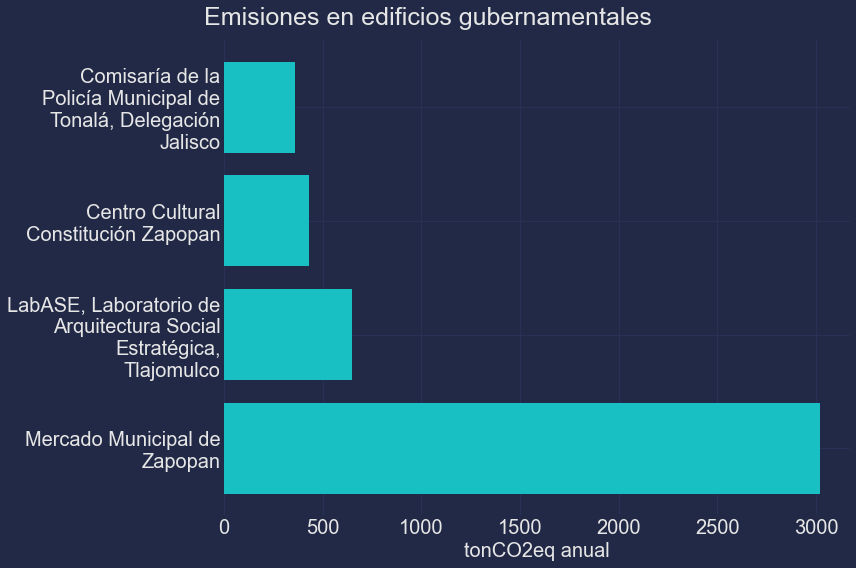

In [32]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
fig, ax = plt.subplots(1,1,figsize=(12,8))
#ax.barh(edificios_gob_['Nombre'].apply(lambda x: ', '.join(x.split(',',maxsplit=2)[0:2])), edificios_gob_['tonCO₂eq'])
ax.barh(edificios_gob_['GraphName'], edificios_gob_['tonCO₂eq'])
ax.set_xlabel('tonCO2eq anual',fontsize=20)
ax.tick_params(labelsize=20)
fig.suptitle('Emisiones en edificios gubernamentales',fontsize=25)
fig.tight_layout()
plt.savefig('../output/figures/emisiones_edificios/EmisionesEdificios_pipV2.png',dpi=300)